Import the libraries to use

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import tensorflow_addons as tfa
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

Configure GPU for Deep Learning

In [2]:
import os
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("Num of GPU's available:",len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

Num of GPU's available: 1


We define the paths for the training, validation and test folders

In [5]:
train_dir = 'C:/Users/fabio/Documents/PlantPathology/images_cnn/train'
validation_dir = 'C:/Users/fabio/Documents/PlantPathology/images_cnn/validation'
test_dir = 'C:/Users/fabio/Documents/PlantPathology/images_cnn/test'

Image processing

In [6]:
#Preprocessing Data
target_size, batch_size = (224,224),20

train_batches = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory = train_dir, target_size = target_size, batch_size = batch_size)

valid_batches = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory = validation_dir, target_size = target_size, batch_size = batch_size)

test_batches = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory = test_dir, target_size = target_size, batch_size = batch_size, shuffle = False)

Found 7556 images belonging to 6 classes.
Found 944 images belonging to 6 classes.
Found 944 images belonging to 6 classes.


In [23]:
imgs, labels =next(train_batches)

In [24]:
#This function will plot images in the form of a grid with 1 row and 10 columns 
def plotImages(images_arr):
    fig,axes = plt.subplots(1,10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

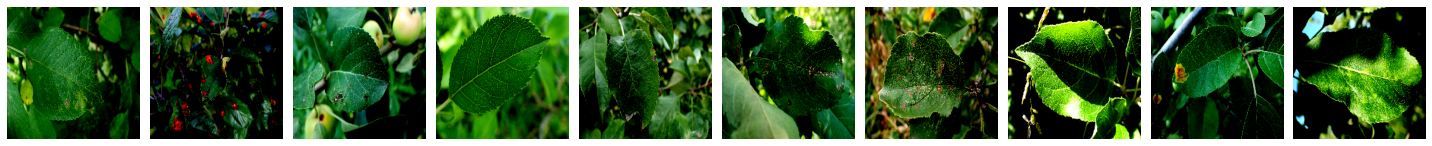

[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]
{'complex': 0, 'frog_eye_leaf_spot': 1, 'healthy': 2, 'powdery_mildew': 3, 'rust': 4, 'scab': 5}


In [25]:
plotImages(imgs)
print(labels[0:9])
print(train_batches.class_indices)

Import MobileNet architecture

In [5]:
seed = 40
tf.random.set_seed(seed)
mobile = tf.keras.applications.MobileNet(input_shape=(224,224,3),
                                                   include_top=False,
                                                   weights="imagenet")
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

Analize trainable layers

In [6]:
pd.set_option("max_colwidth", -1)
info = [(layer, layer.name, layer.trainable) for layer in mobile.layers]
analysis = pd.DataFrame(info, columns = ["Layer Type", "Layer Name", "Train Status"])
analysis

,Layer Type,Layer Name,Train Status
0,<keras.engine.input_layer.InputLayer object at 0x00000202567EF2B0>,input_1,True
1,<keras.layers.convolutional.Conv2D object at 0x000002028DE283D0>,conv1,True
2,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002028DE28A90>,conv1_bn,True
3,<keras.layers.advanced_activations.ReLU object at 0x000002028E01D8B0>,conv1_relu,True
4,<keras.layers.convolutional.DepthwiseConv2D object at 0x000002028E01DAC0>,conv_dw_1,True
...,...,...,...
81,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000020296C3C850>,conv_dw_13_bn,True
82,<keras.layers.advanced_activations.ReLU object at 0x0000020296C3C910>,conv_dw_13_relu,True
83,<keras.layers.convolutional.Conv2D object at 0x00000202957EAC10>,conv_pw_13,True
84,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000020296C47E20>,conv_pw_13_bn,True


Building Model

In [13]:
model = tf.keras.Sequential()
model.add(mobile)
model.add(GlobalAveragePooling2D(),)
model.add(Dense(6,
         kernel_initializer=tf.keras.initializers.RandomUniform(seed=seed),
         bias_initializer=tf.keras.initializers.Zeros(), name='dense', activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 6150      
Total params: 3,235,014
Trainable params: 3,213,126
Non-trainable params: 21,888
_________________________________________________________________


In [14]:
pd.set_option("max_colwidth", -1)
info = [(layer, layer.name, layer.trainable) for layer in model.layers]
analysis = pd.DataFrame(info, columns = ["Layer Type", "Layer Name", "Train Status"])
analysis

,Layer Type,Layer Name,Train Status
0,<keras.engine.functional.Functional object at 0x0000020296C548B0>,mobilenet_1.00_224,True
1,<keras.layers.pooling.GlobalAveragePooling2D object at 0x00000202957D6670>,global_average_pooling2d_1,True
2,<keras.layers.core.Dense object at 0x00000202A95B81F0>,dense,True


Callbacks

In [10]:
f1 = tfa.metrics.F1Score(num_classes=6, average='macro')

#Callbacks
rlp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                           mode='min',
                                           patience=2, 
                                           verbose=0, 
                                           factor=0.5)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                             patience=10, 
                                             verbose=1, 
                                             restore_best_weights=True)
callbacks=[rlp,earlystop]


Compile the Model

In [11]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics=[f1])

Training the model

In [11]:
history = model.fit(train_batches,
                    steps_per_epoch=train_batches.samples//batch_size,
                    validation_data=valid_batches,
                    validation_steps = valid_batches.samples//(batch_size),
                    verbose = 1,
                    epochs=80,
                    callbacks=callbacks)

Epoch 1/80
377/377 [==============================] - 857s 2s/step - loss: 0.6322 - f1_score: 0.7868 - val_loss: 0.3869 - val_f1_score: 0.8731
Epoch 2/80
377/377 [==============================] - 838s 2s/step - loss: 0.3458 - f1_score: 0.8805 - val_loss: 0.5065 - val_f1_score: 0.8382
Epoch 3/80
377/377 [==============================] - 834s 2s/step - loss: 0.2818 - f1_score: 0.9043 - val_loss: 0.5032 - val_f1_score: 0.8427
Epoch 4/80
377/377 [==============================] - 826s 2s/step - loss: 0.1375 - f1_score: 0.9504 - val_loss: 0.3141 - val_f1_score: 0.8942
Epoch 5/80
377/377 [==============================] - 826s 2s/step - loss: 0.0937 - f1_score: 0.9665 - val_loss: 0.4114 - val_f1_score: 0.8838
Epoch 6/80
377/377 [==============================] - 820s 2s/step - loss: 0.0748 - f1_score: 0.9741 - val_loss: 0.3875 - val_f1_score: 0.9037
Epoch 7/80
377/377 [==============================] - 838s 2s/step - loss: 0.0389 - f1_score: 0.9872 - val_loss: 0.3033 - val_f1_score: 0.9136

In [12]:
model.save('prueba2_mobilenet.h5')

Evaluating the model

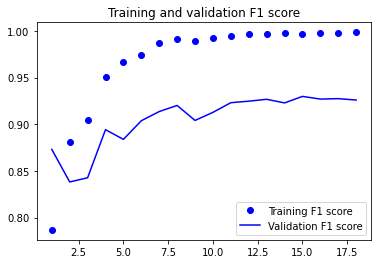

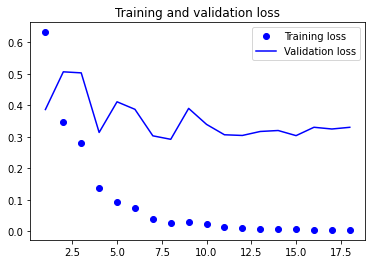

In [13]:
import matplotlib.pyplot as plt
f1_score = history.history['f1_score'] #training
val_f1_score = history.history['val_f1_score']
loss = history.history['loss']  #training
val_loss = history.history['val_loss']
epochs = range(1, len(f1_score) + 1)

plt.plot(epochs, f1_score, 'bo', label='Training F1 score')
plt.plot(epochs, val_f1_score, 'b', label='Validation F1 score')
plt.title('Training and validation F1 score')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [14]:
model.evaluate(train_batches)

378/378 [==============================] - 743s 2s/step - loss: 0.0085 - f1_score: 0.9980


[0.008482815697789192, 0.9980363249778748]

In [15]:
model.evaluate(valid_batches)

48/48 [==============================] - 95s 2s/step - loss: 0.2911 - f1_score: 0.9206


[0.29106956720352173, 0.9205849766731262]

In [16]:
model.evaluate(test_batches)

48/48 [==============================] - 95s 2s/step - loss: 0.3382 - f1_score: 0.9157


[0.33815091848373413, 0.9157019257545471]

Making predictions

In [3]:
model = tf.keras.models.load_model("prueba2_mobilenet.h5")

In [8]:
labels = test_batches.class_indices
type(labels)

dict

In [9]:
#we define a dictionary where labels are contained
labels = {v: k for k, v in labels.items()}
labels

{0: 'complex',
 1: 'frog_eye_leaf_spot',
 2: 'healthy',
 3: 'powdery_mildew',
 4: 'rust',
 5: 'scab'}

In [19]:
#Define a function to process the image
def prepare_image(file):
    img_path='C:/Users/fabio/Documents/PlantPathology/images_cnn/test/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [10]:
#Define a model to predict image
def predict_image(file):
    """
    args
    disease: str, the name of the disease (name of the folder where the images are located)
    file: str, name of the image file (.jpg)
    """
    preprocessed_image = prepare_image(file)
    predictions = model.predict(preprocessed_image)
    result = np.argmax(predictions)
    print("Disease predicted: ", labels[result])
#     print(labels[result])

First prediction

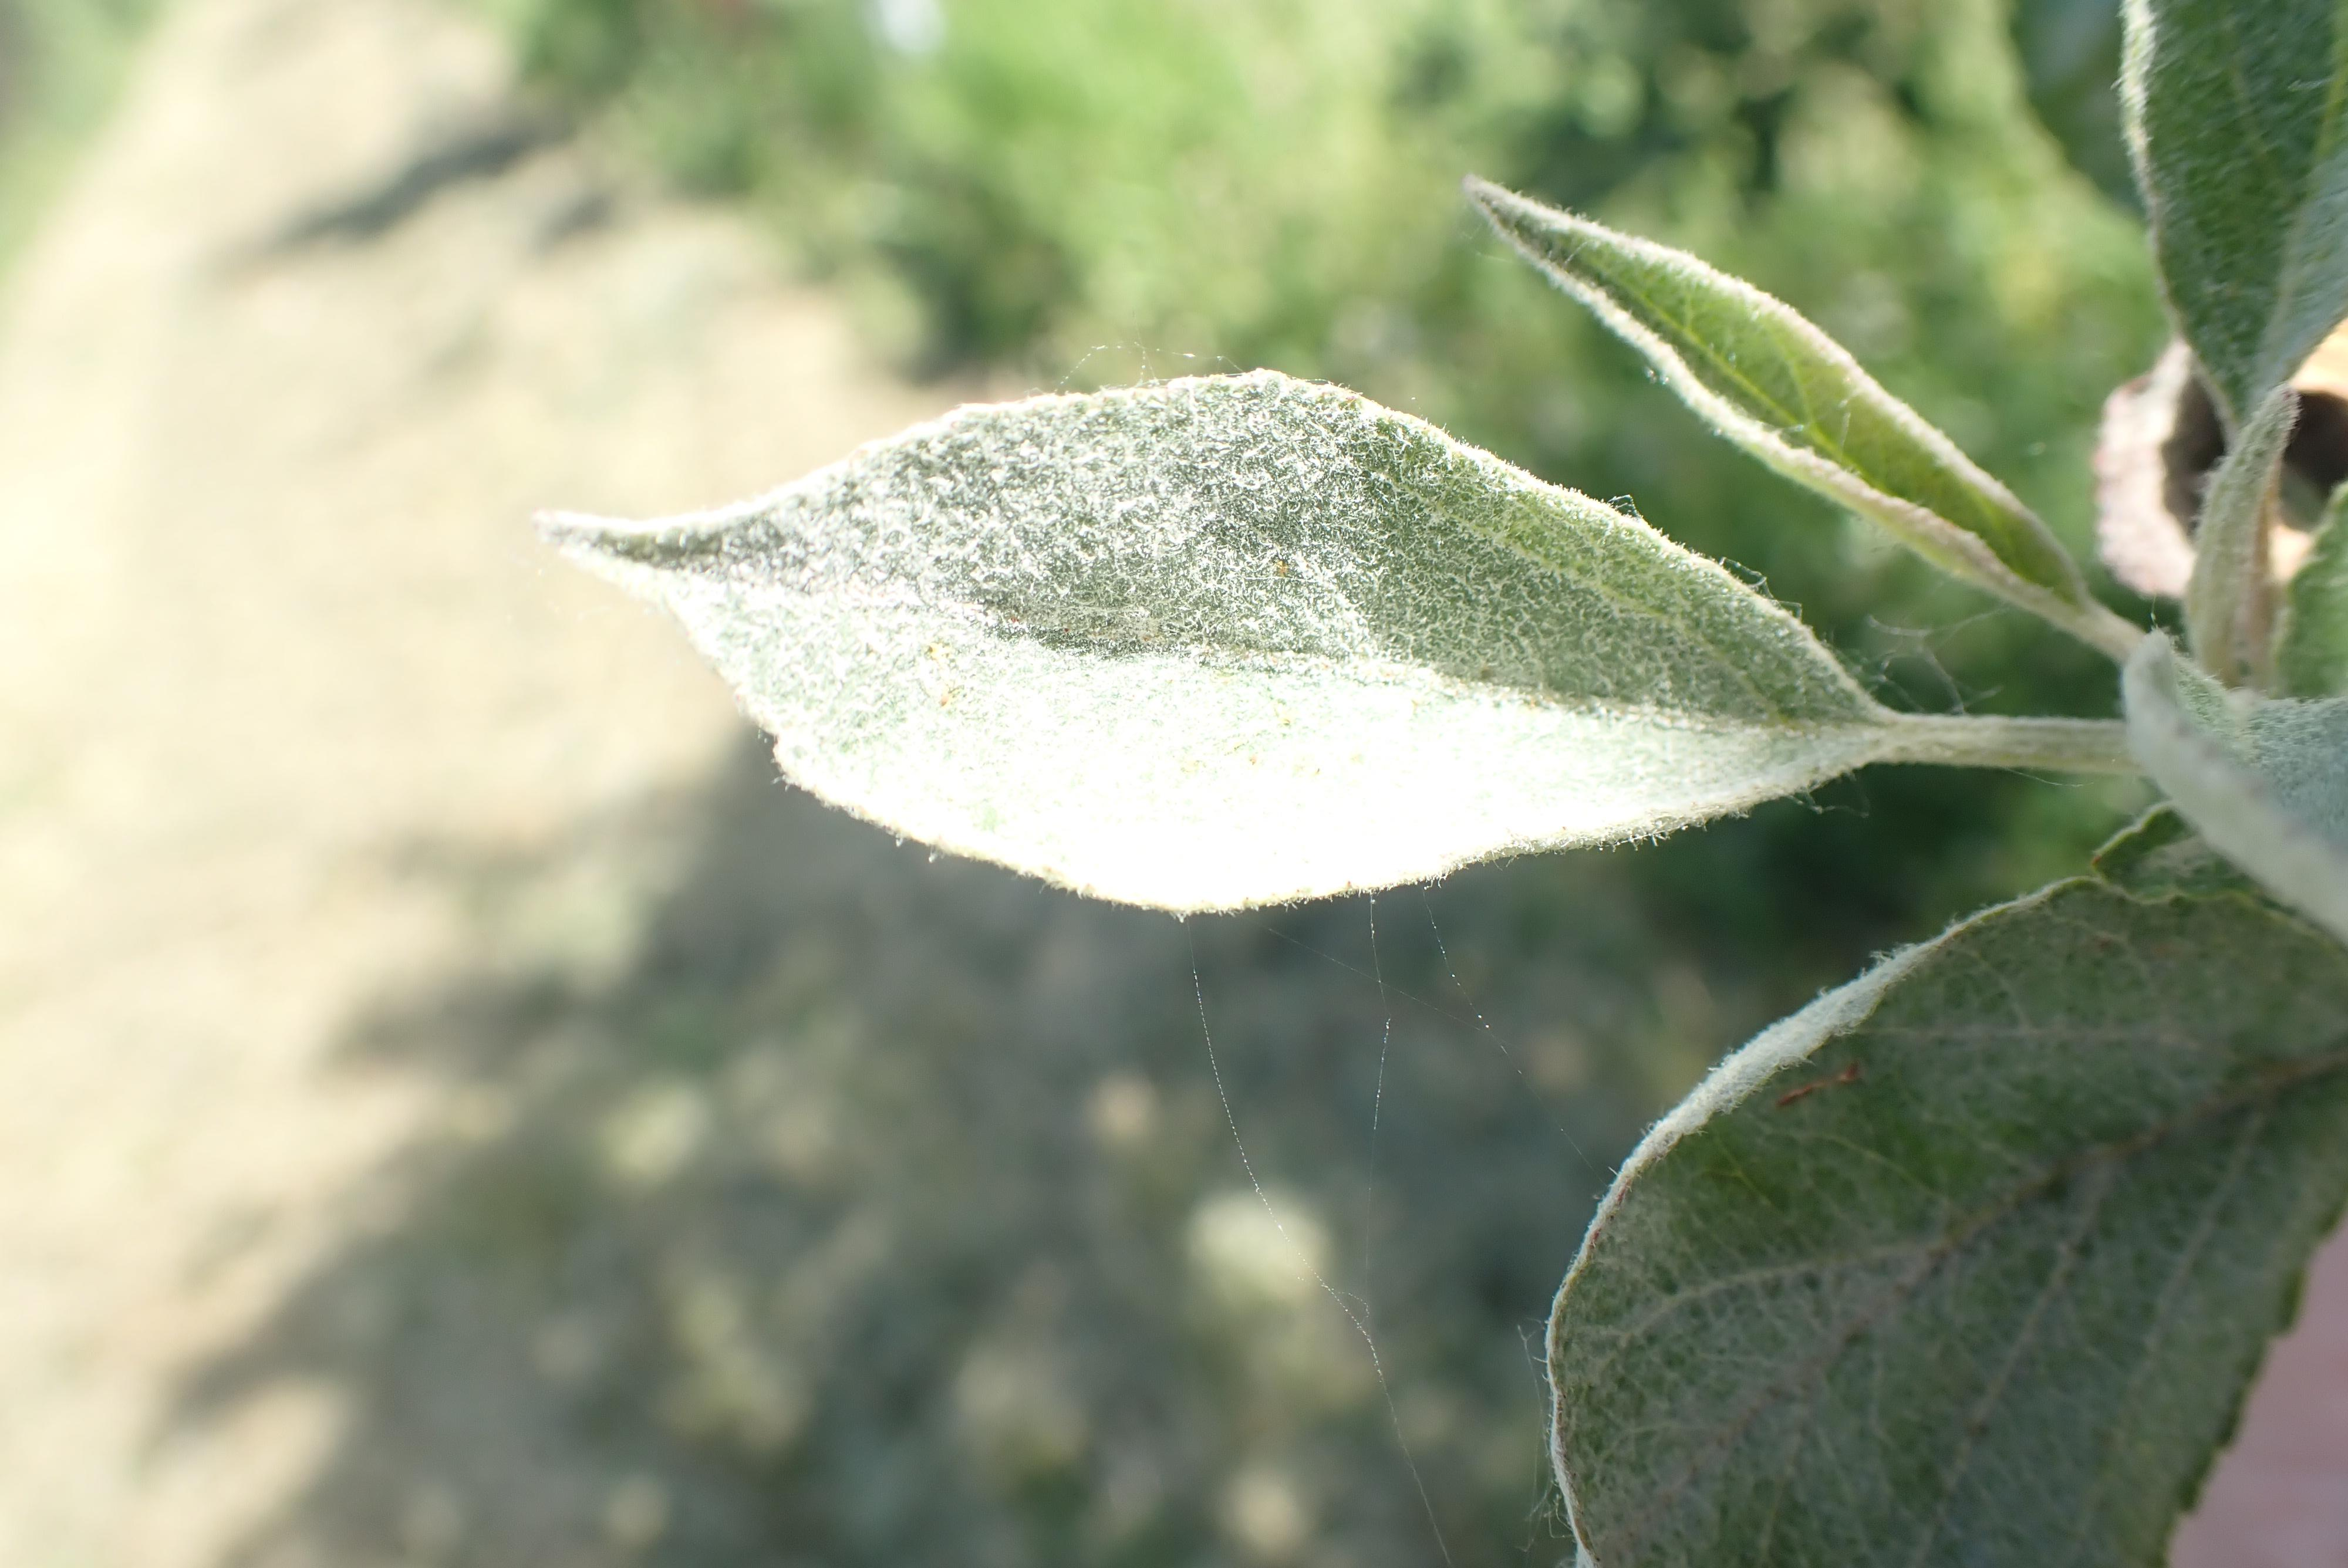

In [20]:
#Show the image to predict, in this case is a powdery mildew class
from IPython.display import Image
Image(filename='C:/Users/fabio/Documents/PlantPathology/images_cnn/test/powdery_mildew/f9c13d7c98ce6409.jpg', width=300,height=200) 

In [37]:
#We introduce the name of the folder (powdery_mildew) and the name of the file (f9c13d7c98ce6409.jpg)
predict_image("powdery_mildew/f9c13d7c98ce6409.jpg")

Disease predicted:  powdery_mildew


Second prediction

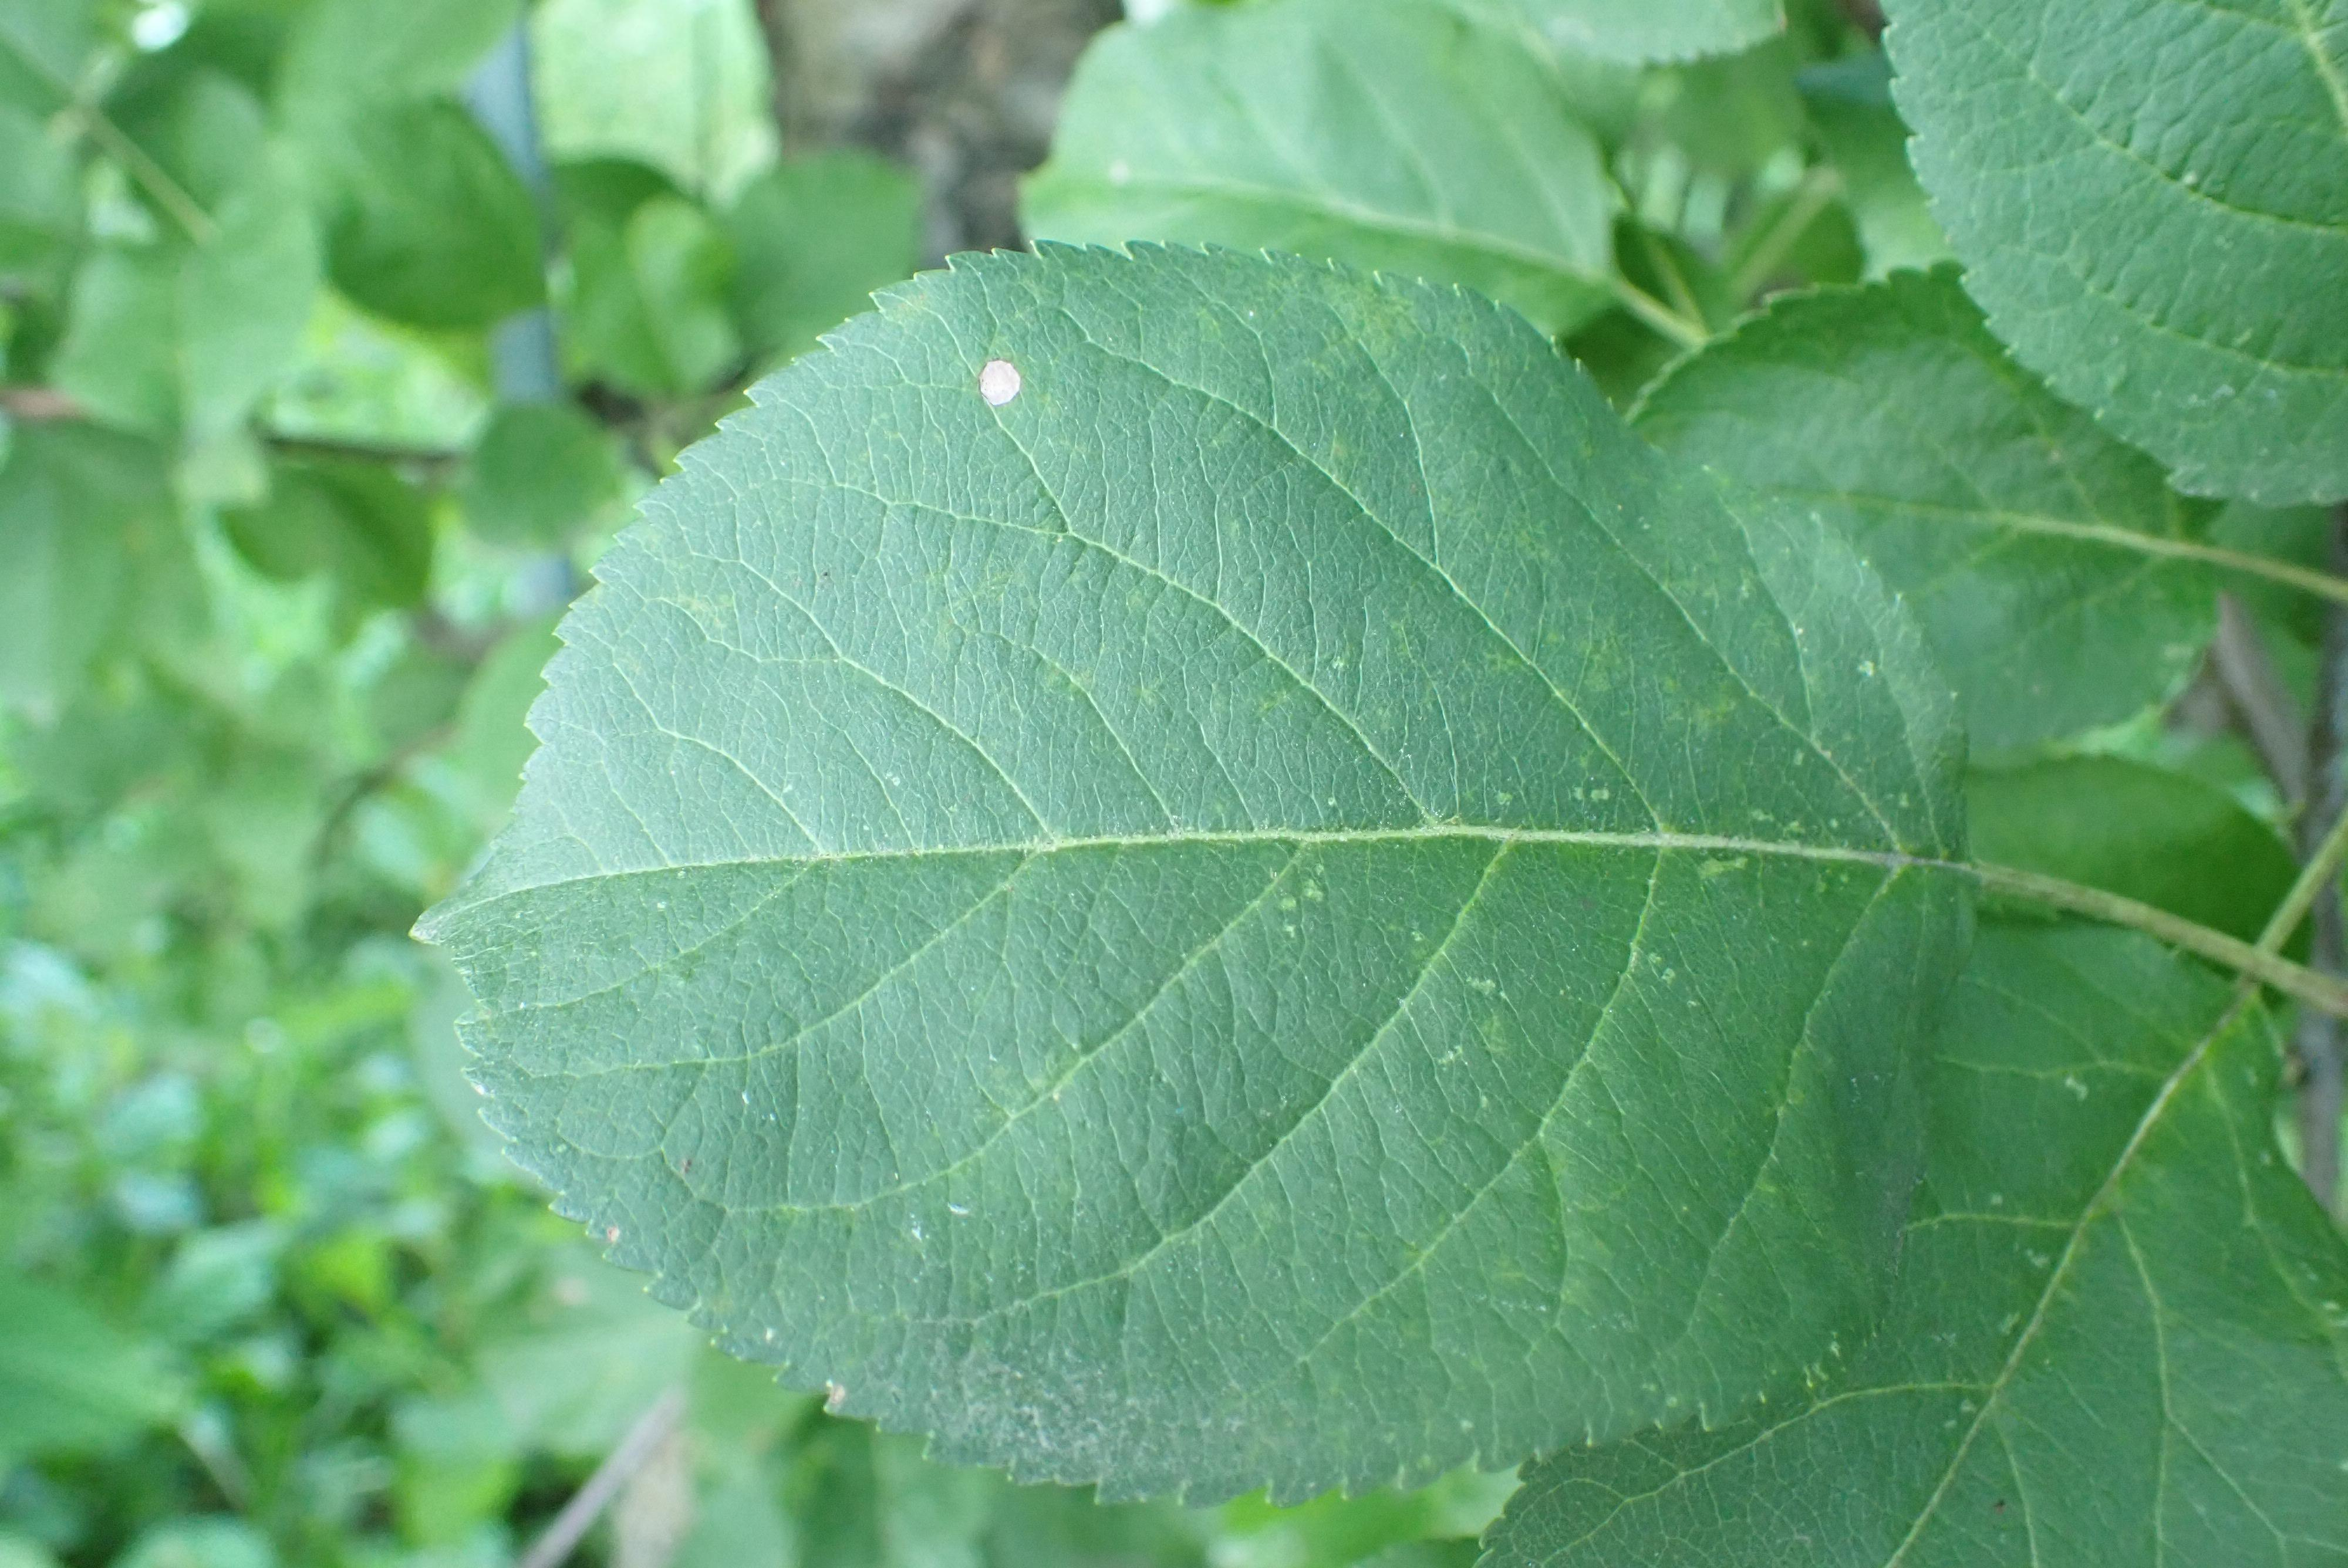

In [38]:
#In this case we have an image of frog eye leaf spot
Image(filename='C:/Users/fabio/Documents/PlantPathology/images_cnn/test/frog_eye_leaf_spot/c39d39fb81c3c2c2.jpg', width=300,height=200) 

In [39]:
predict_image("frog_eye_leaf_spot/c39d39fb81c3c2c2.jpg")

Disease predicted:  frog_eye_leaf_spot


Confusion Matrix

In [24]:
test_labels = test_batches.classes

In [25]:
predictions = model.predict(x = test_batches, verbose = 0)

In [26]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [27]:
def plot_confusion_matrix(cm,classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
    Normalization can be applied by setting 'normalize=True'
    """
    plt.figure(figsize = (10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('confusion matrix, without normalization')
    print(cm)
    thresh = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment='center',
                color="white" if cm[i,j]>thresh else "black")
    plt.tight_layout()
    plt.ylabel("True Label")
    plt.xlabel("Predicted label")

confusion matrix, without normalization
[[121   7   0   3  28   1]
 [ 14 140   0   1   4   1]
 [  0   0 156   2   0   2]
 [  0   0   2 116   0   0]
 [  2   0   0   0 184   0]
 [  3   0   7   3   0 147]]


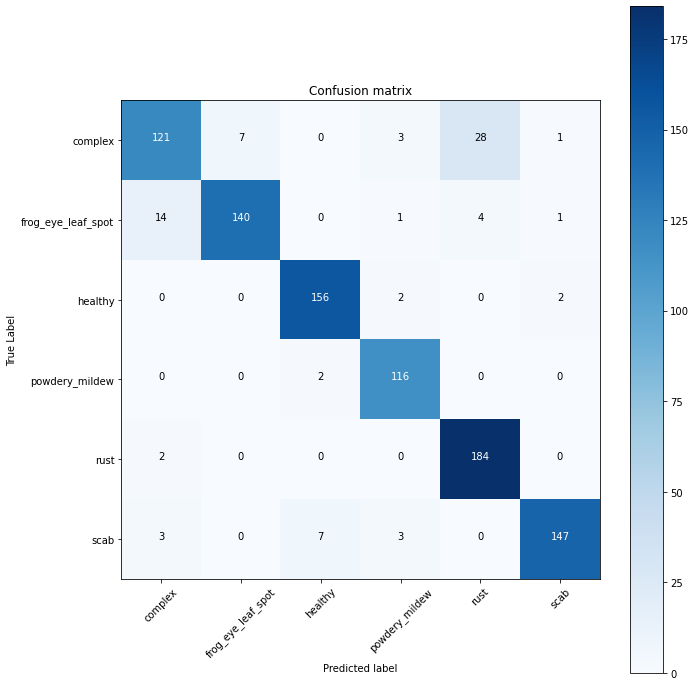

In [28]:
cm_plot_labels=['complex','frog_eye_leaf_spot','healthy','powdery_mildew','rust','scab']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title="Confusion matrix")

Export Model in a Tensorflow Lite file

In [4]:
disease_class = "exp_saved_model"
tf.saved_model.save(model,disease_class)
converter = tf.lite.TFLiteConverter.from_saved_model(disease_class)
tflite_model=converter.convert()
tflite_model_file = "converted_model.tflite"

with open(tflite_model_file, "wb")as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: exp_saved_model\assets


INFO:tensorflow:Assets written to: exp_saved_model\assets


In [5]:
labels = ["complex","frog_eye_leaf_spot","healthy","powdery_mildew","rust","scab"]

with open("label.txt", "w")as f:
    f.write("\n".join(labels))

References:

https://deeplizard.com/learn/video/Zrt76AIbeh4

https://github.com/CodingWitcher/Leaf_Diseases